In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Malware Detection and Classification

/content/drive/MyDrive/Malware Detection and Classification


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten
import pickle

In [22]:
train_url = 'kddcup.data/kddcup.data'
test_url = 'data/NSL_KDD_Test.csv'

In [41]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


df = pd.read_csv(train_url,header=None, names = col_names)

df_test = pd.read_csv(test_url, header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (4898431, 42)
Dimensions of the Test set: (22544, 42)


In [40]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,NaN
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,NaN
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,NaN
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,NaN
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,NaN
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,NaN
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,NaN
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,NaN


In [ ]:
label = pd.Series(df['label'].values)

In [ ]:
categories = label.unique()
categories

array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object)

In [ ]:
categories.shape

(23,)

In [10]:
print('Label distribution Test set:')
print(len(pd.Series(df_test['label'].values).unique()))


Label distribution Test set:
38


### *Đưa dữ liệu về ảnh*

In [33]:
label_mapping = {
    'normal' : 0,
    'neptune' : 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1, 'mailbomb': 1,
    'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1, 'ipsweep' : 2, 'nmap' : 2,
    'portsweep' : 2, 'satan' : 2, 'mscan' : 2, 'saint' : 2, 'ftp_write': 3, 'guess_passwd': 3,
    'imap': 3, 'multihop': 3, 'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3,
    'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 'xlock': 3, 'xsnoop': 3,
    'httptunnel': 3, 'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 'ps': 4,
    'sqlattack': 4, 'xterm': 4
}
len(label_mapping)

40

Sử dụng thuật toán 1 để đưa về thành ảnh

In [36]:
# Replace labels in the training set
df['label'] = df['label'].map(label_mapping)
# Replace labels in the test set
# df_test['label'] = df_test['label'].map(label_mapping)
# Extract labels and features
y_train = df['label']
y_test = df_test['label']
x_train = df.drop('label', axis=1)
x_test = df_test.drop('label', axis=1)

In [38]:
y_train

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
4898426   NaN
4898427   NaN
4898428   NaN
4898429   NaN
4898430   NaN
Name: label, Length: 4898431, dtype: float64

In [29]:
len(label_mapping)

40

In [ ]:
x_test

In [24]:
y_test

0        1
1        1
2        0
3        2
4        2
        ..
22539    0
22540    0
22541    1
22542    0
22543    2
Name: label, Length: 22544, dtype: int64

In [10]:
y_train.to_csv(r'y_train.csv', index=False)
y_test.to_csv(r'y_test.csv', index=False)

In [8]:
from sklearn import preprocessing
def ProcessString(x_train, x_test) :
    le = preprocessing.LabelEncoder()
    x_train['protocol_type'] = le.fit_transform(x_train['protocol_type'])
    x_train['service'] = le.fit_transform(x_train['service'])
    x_train['flag'] = le.fit_transform(x_train['flag'])
    x_test['protocol_type'] = le.fit_transform(x_test['protocol_type'])
    x_test['service'] = le.fit_transform(x_test['service'])
    x_test['flag'] = le.fit_transform(x_test['flag'])
    return x_train, x_test

In [9]:
train_data,test_data = ProcessString(x_train, x_test)

In [ ]:
def dataset_formalization(data_train):
    # Khởi tạo DataFrame mới để lưu trữ dữ liệu đã chuẩn hóa
    new_data = pd.DataFrame(index=data_train.index, columns=data_train.columns)

    # Duyệt qua từng cột của DataFrame
    for c in data_train.columns:
        avg = 0
        r = 0

        avg = data_train[c].mean()  # Tính trung bình của cột
        for index, value in data_train[c].items():
            r = int(value)  # Lấy giá trị của hàng hiện tại
            if r < 122:
                new_val = r * 2
            else:
                if r < 2 * avg:
                    new_val = int((r * 123) / avg)
                else:
                    new_val = 255
            new_data.at[index, c] = new_val
    return new_data

normalized_data = dataset_formalization(train_data)

normalized_data.to_csv('normalized_data.csv', index=False)

In [8]:
normalized_data = pd.read_csv('normalized_data.csv')

In [10]:
normalized_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,2,48,18,14,255,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2,48,18,10,255,0,0,0,0,...,2,2,2,0,2,0,0,0,0,0
2,0,2,48,18,15,138,0,0,0,0,...,4,4,2,0,0,0,0,0,0,0
3,0,2,48,18,15,228,0,0,0,0,...,6,6,2,0,0,0,0,0,0,0
4,0,2,48,18,16,54,0,0,0,0,...,8,8,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,2,48,18,14,255,0,0,0,0,...,6,165,2,0,0,0,0,0,0,0
4898427,0,2,48,18,14,26,0,0,0,0,...,8,165,2,0,0,0,0,0,0,0
4898428,0,2,48,18,14,255,0,0,0,0,...,10,165,2,0,0,0,0,0,0,0
4898429,0,2,48,18,14,138,0,0,0,0,...,12,165,2,0,0,0,0,0,0,0


In [17]:
def d2image(input_data):
    data_array = input_data.values
    num_rows = len(data_array)
    images = np.zeros((num_rows, 7, 7))

    # Iterate through each row and reshape
    for index in range(num_rows):
        row_data = np.zeros(49)  # Create an array of 49 zeros
        actual_data = data_array[index][:49]  # Take the first 49 elements or all available if less than 49
        row_data[:len(actual_data)] = actual_data  # Copy the actual data into the row_data array
        row_data[41:49] = 0  # Zero out elements from index 41 to 48
        images[index] = row_data.reshape((7, 7))

    return images
images = d2image(normalized_data)
images = np.array(images)
images = pickle.dump(images,open('images.sav','wb'))

In [11]:
images = pickle.load(open('images.sav','rb'))
images

array([[[  0.,   2.,  48., ...,  14., 255.,   0.],
        [  0.,   0.,   0., ...,   2.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  2.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   2.,  48., ...,  10., 255.,   0.],
        [  0.,   0.,   0., ...,   2.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  2.,   0.,   0., ...,   2.,   2.,   0.],
        [  2.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[  0.,   2.,  48., ...,  15., 138.,   0.],
        [  0.,   0.,   0., ...,   2.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [  2.,   0.,   0., ...,   4.,   2.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   2.,  48

In [17]:
y_train = np.array(y_train)
y_train
y_test = np.array(y_test)
y_train

array([['normal.'],
       ['normal.'],
       ['normal.'],
       ...,
       ['normal.'],
       ['normal.'],
       ['normal.']], dtype=object)

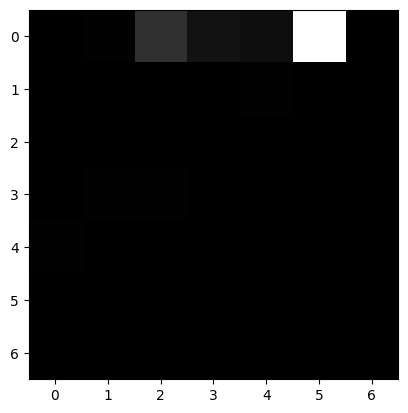

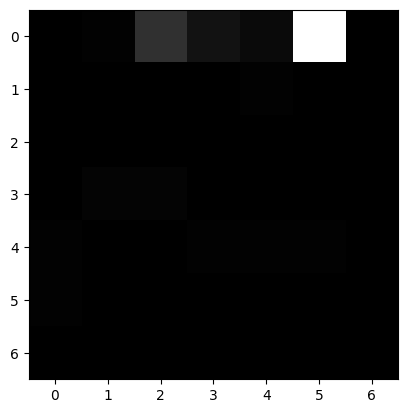

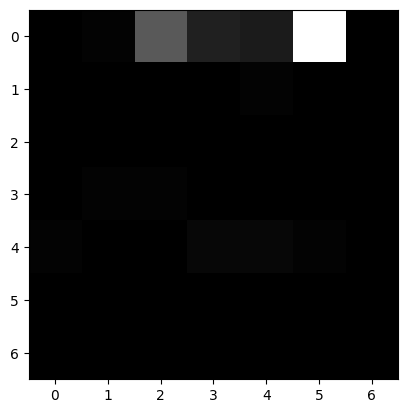

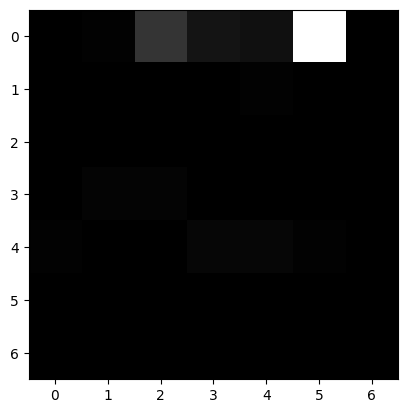

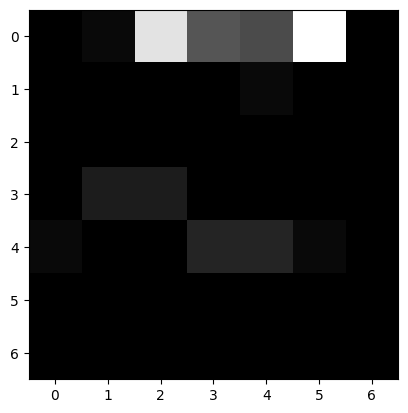

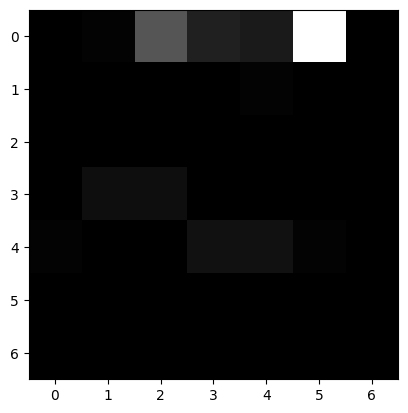

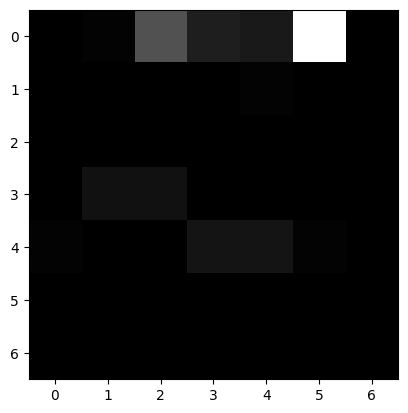

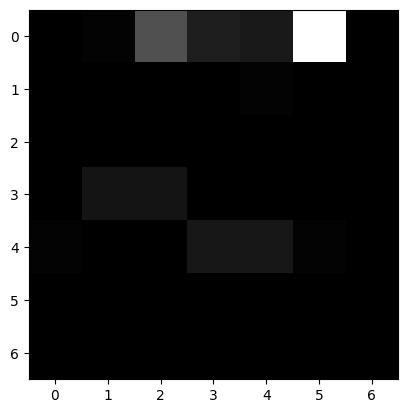

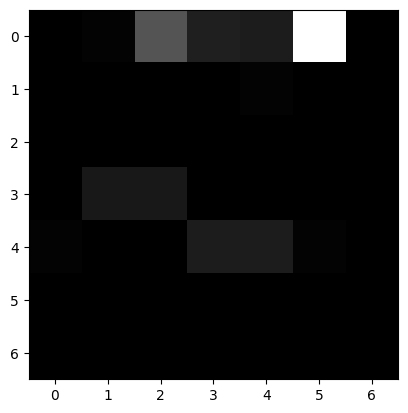

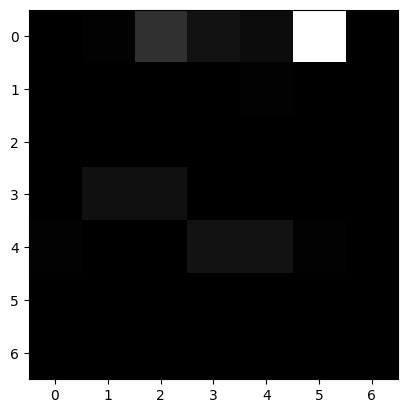

In [11]:
for i in range(10):
    plt.imshow(images[i], cmap='gray')
    plt.show()

In [14]:
y_train = pd.read_csv(r'y_train.csv')
y_test = pd.read_csv(r'y_test.csv')

In [16]:
y_train = y_train.astype(int)

ValueError: invalid literal for int() with base 10: 'normal.'

In [15]:
model = Sequential()

model.add(Conv1D(64, 3, activation="relu", input_shape=(7,7), padding="same"))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, 3, activation="relu", padding="same"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(5, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(images, y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20


UnimplementedError: Graph execution error:

Detected at node sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-15-50ffac9defd5>", line 17, in <cell line: 17>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5725, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 2303, in cast

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2867]

In [ ]:
model.save('cnn_model.h5')

In [ ]:
normolized_test = dataset_formalization(test_data)
test = []
d2image(normolized_test,test)
test

In [ ]:
test = np.array(test)
test.shape

In [ ]:
from sklearn.metrics import accuracy_score

cnn_model = load_model('cnn_model.h5')
y_pred = cnn_model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
y_pred